 1. What is the main difference between outputs from hierarchical and partition-   
 ing clustering algorithms? Why can’t the output from the latter be converted.  
 into the output of the former?   

hierarchical clustering 알고리즘의 경우 한 번 군집으로 나눈 이후에 내부적으로 다시 군집화하는 반면에 partioning의 경우 한 번에 군집으로 전부 나누는 것이라는 차이점이 가장 크다.
따라서 partioning의 결과는 중첩된 군집화를 이루지 않기 때문에 hierarchical의 output으로 converting 할 수 없다.

2. Is MSCI’s GICS classification system an example of hierarchical or parti-    
tioning clustering? Using the appropriate algorithm on a correlation matrix,    
try to replicate the MSCI classification. To compare the clustering output.   
with MSCI’s, use the clustering distance introduced in Section 3.   

GICS classification의 경우 sector, industry group, industy, subindustry로 계속 나누어가기 때문에 hierarchical clustering이다. 

3. Modify Code Snippets 4.1 and 4.2 to work with a spectral biclustering algorithm.  
Do you get fundamentally different results? Hint: Remember that, as proximity,    
matrix, biclustering algorithms expect a similarity matrix, not a distance matrix.    

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples

def cluster_spectral_base(corr:pd.DataFrame, max_num_clusters=10, n_init=10):
    '''
    n_init을 여러번 하고 최대 max_num_clusters만큼 cluster를 만들어보면서 Spectral Clustering의 initialization 문제를 최소화하고 최적의 cluster 개수를 선정하여 결과를 반환하는 함수
    '''
    corr_filled = corr.fillna(0.0).clip(-1.0, 1.0)
    d = np.sqrt(0.5 * (1.0 - corr_filled))                          # [0,1] 거리행렬, 대각 0
    # 유사도(커널). DataFrame 유지(라벨 보존) 위해 명시적으로 감쌈
    k = pd.DataFrame(np.exp(-(d.values**2)), index=corr.index, columns=corr.columns)

    best_cluster_quality=None
    best_sil=None
    best_spectral=None
    for _ in range(n_init): # multi initialization
        for i in range(2, max_num_clusters+1):
            spectral=SpectralClustering(n_clusters=i, n_init=1, affinity='precomputed').fit(k.values)
            sil=silhouette_samples(d.values, spectral.labels_)
            cluster_quality=sil.mean()/sil.std() # cluster score
            if best_cluster_quality is None or best_cluster_quality<cluster_quality:
                best_cluster_quality=cluster_quality
                best_sil=pd.Series(sil, index=corr.index)
                best_spectral=spectral

    sorted_idx=np.argsort(best_spectral.labels_)
    ret_corr=corr.iloc[sorted_idx] # reorder rows by cluster result
    ret_corr=corr.iloc[:, sorted_idx] # reorder columns by cluster result

    cluster_dict={i:corr.columns[np.where(best_spectral.labels_==i)[0].tolist()] for i in np.unique(best_spectral.labels_)}
    return ret_corr, cluster_dict, best_sil

In [2]:

def cluster_spectral_top(corr:pd.DataFrame, max_num_clusters=None, n_init=10):
    def override_cluster_result(corr:pd.DataFrame, cluster_dict_ori:dict, cluster_dict_new:dict):
        new_cluster_dict_ret={}
        for label in cluster_dict_ori.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_ori[label])
        for label in cluster_dict_new.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_new[label]) # override

        # reindex correlation matrix
        new_idx=[idx for i in new_cluster_dict_ret.keys() for idx in new_cluster_dict_ret[i]]
        corr_new=corr.loc[new_idx, new_idx]

        # recalculate sil score
        corr_filled = corr.fillna(0.0).clip(-1.0, 1.0)
        d = np.sqrt(0.5 * (1.0 - corr_filled))                          # [0,1] 거리행렬, 대각 0
        # 유사도(커널). DataFrame 유지(라벨 보존) 위해 명시적으로 감쌈
        k = pd.DataFrame(np.exp(-(d.values**2)), index=corr.index, columns=corr.columns)
        spectral_label=np.zeros(len(corr.columns))
        for i in new_cluster_dict_ret.keys():
            cur_idx=[k.index.get_loc(data) for data in new_cluster_dict_ret[i]]
            spectral_label[cur_idx]=i
        sil_new=pd.Series(silhouette_samples(d.values, spectral_label), index=k.index)
        return corr_new, new_cluster_dict_ret, sil_new
    '''
    cluster_spectral_top 더하여 cluster마다 결과가 좋지 못했던 cluster만 모아서 재학습을 시켜 전반적인 cluster quality를 올리는 알고리즘
    '''
    if max_num_clusters is None: max_num_clusters=corr.shape[0]-1

    ret_corr, cluster_dict, best_sil=cluster_spectral_base(corr, max_num_clusters, n_init)

    cluster_quality_dict={
        label:np.mean(best_sil[cluster_dict[label]])/np.std(best_sil[cluster_dict[label]])     
        if np.std(best_sil[cluster_dict[label]]) != 0 else 0
        for label in cluster_dict.keys()
    }

    mean_cluter_quality=np.sum(list(cluster_quality_dict.values()))/len(cluster_quality_dict)

    bad_cluster_labels=[label for label in cluster_quality_dict.keys() if cluster_quality_dict[label]<mean_cluter_quality]

    if len(bad_cluster_labels)<=1:
        return ret_corr, cluster_dict, best_sil
    else:
        bad_cluster_data_index=[data_index for label in bad_cluster_labels for data_index in cluster_dict[label]]
        bad_data_corr=corr.loc[bad_cluster_data_index, bad_cluster_data_index]
        mean_bad_cluster_quality=np.mean([cluster_quality_dict[label] for label in bad_cluster_labels])

        recluster_corr, recluster_cluster_dict, recluster_sil=cluster_spectral_top(bad_data_corr, min(max_num_clusters, bad_data_corr.shape[0]-1), n_init)

       # remake new output
        corr_new, cluster_dict_new, silh_new=override_cluster_result(corr, {label:cluster_dict[label] for label in cluster_dict.keys() if label not in bad_cluster_labels}, recluster_cluster_dict)

        mean_new_cluster_quality = np.mean([
            np.mean(silh_new[cluster_dict_new[label]]) / std
            if (std := np.std(silh_new[cluster_dict_new[label]])) != 0 else 0
            for label in cluster_dict_new.keys()
        ])

        if mean_new_cluster_quality<=mean_bad_cluster_quality: # cluster 개선 X
            return ret_corr, cluster_dict, best_sil
        else: # cluster 개선 O
            return corr_new, cluster_dict_new, silh_new


In [3]:
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt


def get_random_block_cov(n_cols:int, n_blocks:int, sigma=0.1, min_block_size=1, random_state=None):
    rng=check_random_state(random_state)

    sizes=rng.choice(range(1, n_cols-(min_block_size-1)*n_blocks), n_blocks-1, replace=False)
    sizes.sort()
    sizes=np.append(sizes, n_cols-(min_block_size-1)*n_blocks)
    sizes=np.append(sizes[0], np.diff(sizes))+min_block_size-1

    def get_block_cov(n_obs:int, n_cols:int, sigma:float, random_state=None):
        rng=check_random_state(random_state)
        if n_cols==1: return np.ones((n_cols, n_cols))
        col=rng.normal(size=(n_obs, 1))
        matrix=np.repeat(col, n_cols, axis=1)
        matrix+=rng.normal(scale=sigma, size=matrix.shape)
        cov=np.cov(matrix, rowvar=False)
        return cov

    ret=None
    for s in sizes:
        n_obs=int(max(s*(s+1)/2, 100))
        cov=get_block_cov(n_obs, s, sigma, random_state)
        if ret is None: ret=cov
        else: ret=block_diag(ret, cov)
    return ret


def get_random_block_corr(n_cols:int, n_blocks:int, sigma_s:float, sigma_b:float, min_block_size=1, random_state=None):
    rng=check_random_state(random_state)

    cov_s=get_random_block_cov(n_cols, n_blocks, sigma_s, min_block_size, rng)
    cov_b=get_random_block_cov(n_cols, 1, sigma_b, min_block_size, rng)

    def get_corr_matrix(cov:pd.DataFrame):
        std=np.sqrt(np.diag(cov))
        corr=cov/np.outer(std, std)
        np.clip(corr, -1.0, 1.0, out=corr)
        return corr

    ret_cov=cov_s+cov_b
    ret_corr=get_corr_matrix(ret_cov)
    labels=[f"{i}" for i in range(n_cols)]
    ret_corr=pd.DataFrame(ret_corr, index=labels, columns=labels)
    return ret_corr

In [4]:
from collections import defaultdict

trial_counts=10
trial_ret=defaultdict(list)
for n_cols in [20, 40]:
    for n_blocks in range(3, int(n_cols/2), 3):
        key=np.round(n_blocks/n_cols, 2)
        correct_cnt=0
        for _ in range(trial_counts):
            corr=get_random_block_corr(n_cols, n_blocks, 0.5, 1, min_block_size=2)
            corr_new, cluster_dict, sil=cluster_spectral_top(corr)
            if len(cluster_dict)==n_blocks:
                correct_cnt+=1
        correct_ratio=float(correct_cnt/trial_counts)
        trial_ret[key].append(correct_ratio)
    

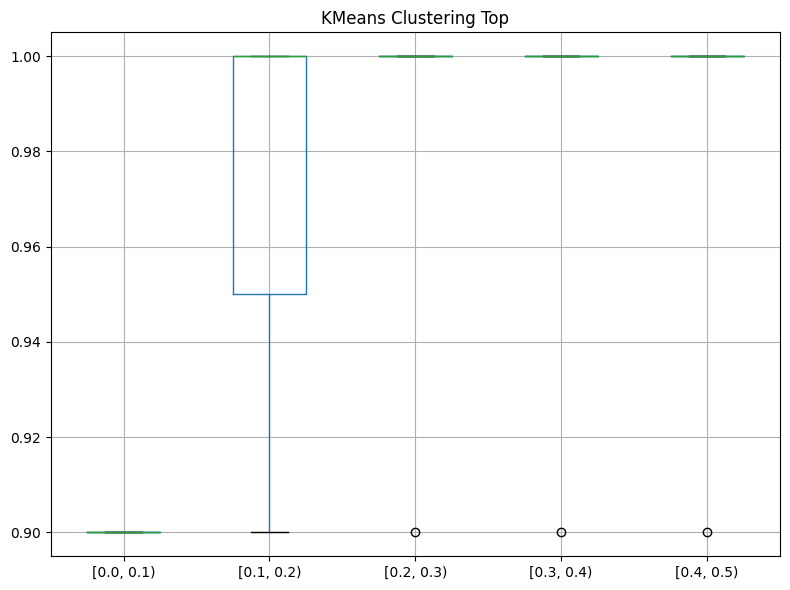

In [5]:
data_dict = {}
for decile in np.arange(0.1, 0.6, 0.1):
    cur_data = []
    for k, v in trial_ret.items():
        if k < float(decile):
            cur_data.extend(v)
    data_dict[decile] = cur_data

decile_df = pd.DataFrame(dict([(f"[{k-0.1:.1f}, {k:.1f})", pd.Series(v)) for k, v in data_dict.items()]))

fig, ax = plt.subplots(figsize=(8, 6))
decile_df.boxplot(ax=ax)
ax.set_title("KMeans Clustering Top")

plt.tight_layout()
plt.show()


4. Repeat the experimental analysis, where this time ONC’s base algorithm
selects the number of clusters using the“elbow method.” Do you recover the
true number of clusters consistently? Why?

elbow method를 사용하더라도 cluster의 qualtity를 계속 recursive하게 개선하는 것이 아니라서 이전의 cluster_kmeans_top에 비해서는 cluster를 복원하는 능력이 부족하다.

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

def cluster_kmeans_base(corr:pd.DataFrame, max_num_clusters=10, n_init=10):
    '''
    n_init을 여러번 하고 최대 max_num_clusters만큼 cluster를 만들어보면서 k-mean의 initialization 문제를 최소화하고 최적의 cluster 개수를 선정하여 결과를 반환하는 함수
    '''
    x=np.sqrt(0.5*(1-corr.fillna(0))) # distance of features

    best_cluster_quality=None
    best_sil=None
    best_kmeans=None
    for _ in range(n_init): # multi initialization
        for i in range(2, max_num_clusters+1):
            kmeans=KMeans(n_clusters=i, n_init=1).fit(x)
            sil=silhouette_samples(x, kmeans.labels_)
            cluster_quality=sil.mean()/sil.std() # cluster score
            if best_cluster_quality is None or best_cluster_quality<cluster_quality:
                best_cluster_quality=cluster_quality
                best_sil=pd.Series(sil, index=x.index)
                best_kmeans=kmeans

    sorted_idx=np.argsort(best_kmeans.labels_)
    ret_corr=corr.iloc[sorted_idx] # reorder rows by cluster result
    ret_corr=corr.iloc[:, sorted_idx] # reorder columns by cluster result

    cluster_dict={i:corr.columns[np.where(best_kmeans.labels_==i)[0].tolist()] for i in np.unique(best_kmeans.labels_)}
    return ret_corr, cluster_dict, best_sil

def cluster_kmeans_top(corr:pd.DataFrame, max_num_clusters=None, n_init=10):
    '''
    cluster_kmeans_base에 더하여 cluster마다 결과가 좋지 못했던 cluster만 모아서 재학습을 시켜 전반적인 cluster quality를 올리는 알고리즘
    '''
    def override_cluster_result(corr:pd.DataFrame, cluster_dict_ori:dict, cluster_dict_new:dict):
        new_cluster_dict_ret={}
        for label in cluster_dict_ori.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_ori[label])
        for label in cluster_dict_new.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_new[label]) # override

        # reindex correlation matrix
        new_idx=[idx for i in new_cluster_dict_ret.keys() for idx in new_cluster_dict_ret[i]]
        corr_new=corr.loc[new_idx, new_idx]

        # recalculate sil score
        x=np.sqrt(0.5*(1-corr.fillna(0))) # distance of features
        kmeans_lables=np.zeros(len(x.columns))
        for i in new_cluster_dict_ret.keys():
            cur_idx=[x.index.get_loc(k) for k in new_cluster_dict_ret[i]]
            kmeans_lables[cur_idx]=i
        sil_new=pd.Series(silhouette_samples(x.values, kmeans_lables), index=x.index)
        return corr_new, new_cluster_dict_ret, sil_new
    if max_num_clusters is None: max_num_clusters=corr.shape[0]-1

    ret_corr, cluster_dict, best_sil=cluster_kmeans_base(corr, max_num_clusters, n_init)

    cluster_quality_dict={
        label:np.mean(best_sil[cluster_dict[label]])/np.std(best_sil[cluster_dict[label]])     
        if np.std(best_sil[cluster_dict[label]]) != 0 else 0
        for label in cluster_dict.keys()
    }

    mean_cluter_quality=np.sum(list(cluster_quality_dict.values()))/len(cluster_quality_dict)

    bad_cluster_labels=[label for label in cluster_quality_dict.keys() if cluster_quality_dict[label]<mean_cluter_quality]

    if len(bad_cluster_labels)<=1:
        return ret_corr, cluster_dict, best_sil
    else:
        bad_cluster_data_index=[data_index for label in bad_cluster_labels for data_index in cluster_dict[label]]
        bad_data_corr=corr.loc[bad_cluster_data_index, bad_cluster_data_index]
        mean_bad_cluster_quality=np.mean([cluster_quality_dict[label] for label in bad_cluster_labels])

        recluster_corr, recluster_cluster_dict, recluster_sil=cluster_kmeans_top(bad_data_corr, min(max_num_clusters, bad_data_corr.shape[0]-1), n_init)

        # remake new output
        corr_new, cluster_dict_new, silh_new=override_cluster_result(corr, {label:cluster_dict[label] for label in cluster_dict.keys() if label not in bad_cluster_labels}, recluster_cluster_dict)

        mean_new_cluster_quality = np.mean([
            np.mean(silh_new[cluster_dict_new[label]]) / std
            if (std := np.std(silh_new[cluster_dict_new[label]])) != 0 else 0
            for label in cluster_dict_new.keys()
        ])

        if mean_new_cluster_quality<=mean_bad_cluster_quality: # cluster 개선 X
            return ret_corr, cluster_dict, best_sil
        else: # cluster 개선 O
            return corr_new, cluster_dict_new, silh_new


Auto Find Elbow Algorithm

In [7]:
from kneed import KneeLocator

def kmeans_elbow_kneedle(X, k_range=range(2, 11)):
    x = np.sqrt(0.5 * (1 - X.fillna(0)))
    inertia_values = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(x)
        inertia_values.append(km.inertia_)
    kn = KneeLocator(list(k_range), inertia_values, curve='convex', direction='decreasing')
    return kn.knee, inertia_values

In [8]:
from collections import defaultdict

trial_counts=30
trial_ret=defaultdict(list)
trial_ret_elbow=defaultdict(list)
for n_cols in [20, 40, 80, 160]:
    for n_blocks in range(5, int(n_cols/2), 5):
        key=np.round(n_blocks/n_cols, 2)
        correct_cnt=0
        correct_cnt_elbow=0
        for _ in range(trial_counts):
            corr=get_random_block_corr(n_cols, n_blocks, 0.5, 1, min_block_size=2)
            corr_new, cluster_dict, sil=cluster_kmeans_top(corr)
            pred_cluster_cnt, _=kmeans_elbow_kneedle(corr, range(2, n_cols))
            if len(cluster_dict)==n_blocks:
                correct_cnt+=1
            if pred_cluster_cnt==n_blocks:
                correct_cnt_elbow+=1
        correct_ratio=float(correct_cnt/trial_counts)
        correct_ratio_elbow=float(correct_cnt_elbow/trial_counts)
        trial_ret[key].append(correct_ratio)
        trial_ret_elbow[key].append(correct_ratio_elbow)



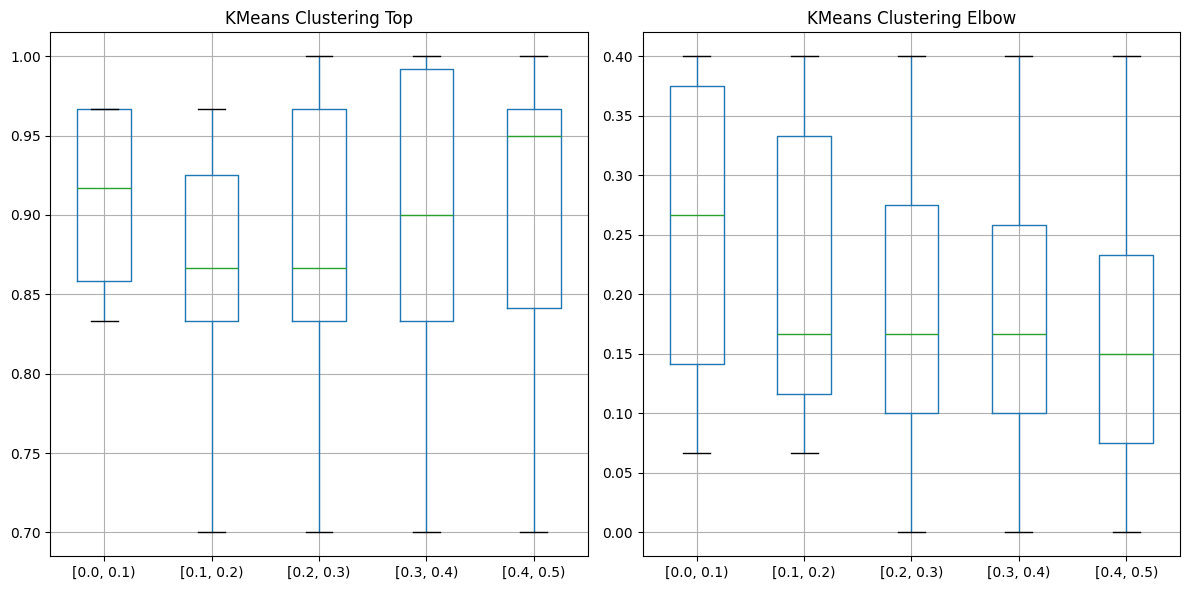

In [9]:
def get_decile_df(trial_ret:dict):
    data_dict = {}
    for decile in np.arange(0.1, 0.6, 0.1):
        cur_data = []
        for k, v in trial_ret.items():
            if k < float(decile):
                cur_data.extend(v)
        data_dict[decile] = cur_data

    decile_df = pd.DataFrame(dict([(f"[{k-0.1:.1f}, {k:.1f})", pd.Series(v)) for k, v in data_dict.items()]))
    return decile_df

decile_df = get_decile_df(trial_ret)
decile_df_elbow = get_decile_df(trial_ret_elbow)

fig, axes=plt.subplots(1, 2, figsize=(12, 6))
decile_df.boxplot(ax=axes[0])
axes[0].set_title("KMeans Clustering Top")

decile_df_elbow.boxplot(ax=axes[1])
axes[1].set_title("KMeans Clustering Elbow")

plt.tight_layout()
plt.show()


5. In Section 2, we used a different method for building block-diagonal correlation matrices.   
In that method, all blocks had the same size. 
Repeat the experimental analysis on regular block-diagonal correlation matrices. 
Do you get better or worse results? Why?

확실히 이전에 비해서 box plot의 값들을 보면 correct ratio가 더 높은것을 확인할 수 있어 기존에 비해서 성능이 향상된것을 확인할 수 있다.
그 이유는 사이즈가 같다면 clustering을 할때 이상치에 가까운 cluster(내부에 데이터가 1~2개)가 없을 가능성이 높아 cluster 연산의 안정성이 높기 때문이다

In [10]:
np.random.seed(0)
import scipy

def get_block_matrix(n_blocks:int, b_size:int, b_corr:float, sigma:float): # S&P500의 correlation matrix와 유사하게 만들기 위함
    '''
    Generate a block diagonal matrix with specified number of blocks, block size, and block correlation.
    '''
    block=np.ones((b_size, b_size))*b_corr
    block[np.diag_indices(b_size)]=1
    block+=np.random.normal(scale=sigma, size=block.shape) # add noise
    corr=scipy.linalg.block_diag(*[block]*n_blocks)
    return corr

def get_random_block_corr_same_size(n_cols:int, n_blocks:int, sigma_s:float, sigma_b:float, random_state=None):
    rng=check_random_state(random_state)

    corr_s=get_block_matrix(n_blocks, n_cols//n_blocks, 0.5, sigma_s)
    corr_b=get_block_matrix(1, (n_cols//n_blocks)*n_blocks, 0, sigma_b)

    def get_corr_matrix(cov: np.ndarray):
        # 대칭화 (수치 오차 방지)
        cov = (cov + cov.T) / 2.0

        # 분모가 0 되지 않게 대각을 안전하게 처리
        d = np.sqrt(np.clip(np.diag(cov), 1e-12, None))  # 음수/0 방지
        denom = np.outer(d, d)

        corr = cov / denom
        corr = (corr + corr.T) / 2.0            # 재대칭화
        np.fill_diagonal(corr, 1.0)             # 대각 1 강제
        np.clip(corr, -1.0, 1.0, out=corr)      # 수치 오차 클립
        return corr

    ret_corr=corr_s+corr_b
    ret_corr=get_corr_matrix(ret_corr)
    labels=[f"{i}" for i in range(len(ret_corr))]
    ret_corr=pd.DataFrame(ret_corr, index=labels, columns=labels)
    return ret_corr    

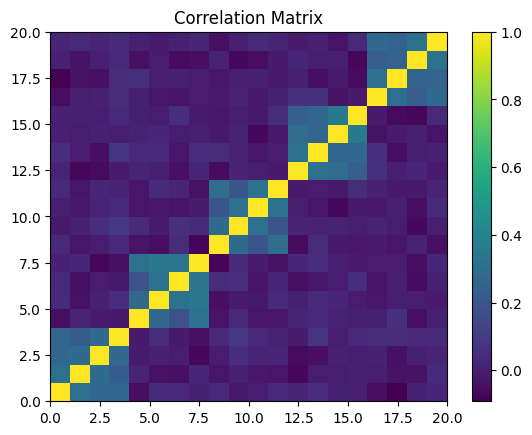

In [11]:
corr_matrix = get_random_block_corr_same_size(20, 5, 0.1, 0.1)

plt.pcolor(corr_matrix)
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()


In [12]:
from collections import defaultdict

trial_counts=30
trial_ret=defaultdict(list)
for n_cols in [20, 40, 80, 160]:
    for n_blocks in range(5, int(n_cols/2), 5):
        key=np.round(n_blocks/n_cols, 2)
        correct_cnt=0
        for _ in range(trial_counts):
            corr_matrix= get_random_block_corr_same_size(n_cols, n_blocks, 0.1, 0.1)
            corr_new, cluster_dict, sil=cluster_spectral_top(corr_matrix)
            if len(cluster_dict)==n_blocks:
                correct_cnt+=1
        correct_ratio=float(correct_cnt/trial_counts)
        trial_ret[key].append(correct_ratio)
    

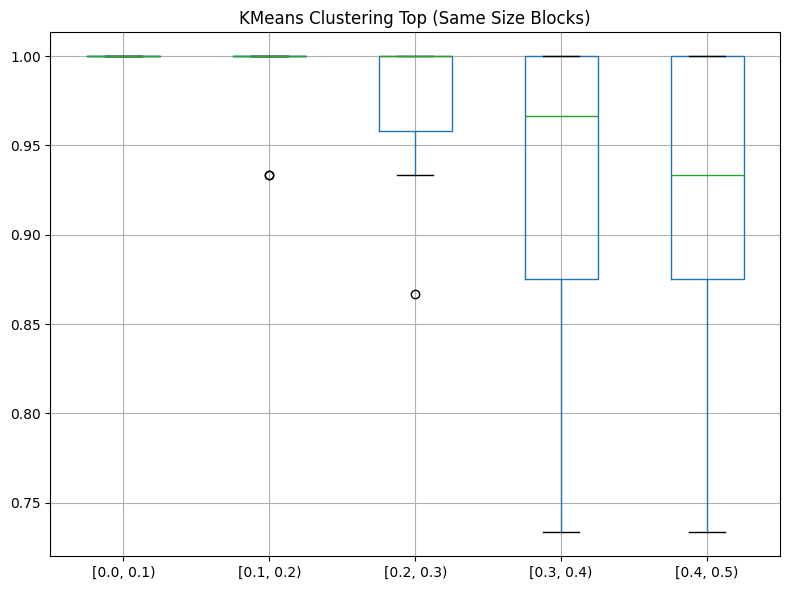

In [13]:
same_size_decild_df=get_decile_df(trial_ret)

fig, ax = plt.subplots(figsize=(8, 6)) 
same_size_decild_df.boxplot(ax=ax)
ax.set_title("KMeans Clustering Top (Same Size Blocks)")

plt.tight_layout()
plt.show()